In [2]:
from Serial_ import *
ser_Collector= serial.Serial('/dev/ttyACM1',115200)

19

In [6]:
ser_Collector.write(b'G1 R1500 L2100 \r\n')

17

In [9]:
ser_Collector.write(b'G1 R-1500 L-2100 \r\n')

19

In [1]:
import numpy as np
import math

##Server
import  time, sys , serial
import threading
import pprint
import time
from Serial_ import *
SERIAL_PORT_ROBOT = '/dev/ttyACM0'
SERIAL_PORT_COllECTOR = '/dev/ttyACM1'
SERIAL_RATE = 115200
import threading
from collections import deque
import TCP_IP as Tcp_Ip
clientCount = 0
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import matplotlib.pyplot as plt
from parse import *
from ast import literal_eval as make_tuple
%matplotlib inline

def GenerateTimeout(Set_Coordinate, robot_pos):
    X_Robot , Y_Robot, A_Robot = robot_pos[0] , robot_pos[1] , robot_pos[2]
    for i in range(len(Set_Coordinate)): 
        time_out_com = math.sqrt( np.float_power(Set_Coordinate[i,0]-X_Robot , 2) + np.float_power(Set_Coordinate[i,1]-Y_Robot , 2) ) / Set_Coordinate[i,2]
        Set_Coordinate[i,3] = time_out_com*1400 + 2000# 140 %(For incertenties +500 ms(For initial acceleration)
        X_Robot = Set_Coordinate[i,0]
        Y_Robot = Set_Coordinate[i,1]
    return Set_Coordinate

def Build_and_Send(Set_Coordinate):
    X_Des=Set_Coordinate[0]
    Y_Des=Set_Coordinate[1]
    Max_Speed=Set_Coordinate[2]
    TimeOut=Set_Coordinate[3]
    Backward_Parameter=Set_Coordinate[4]
    """Create messages"""
    Dump='\r\n'
    G0_String='G0 X' + str(X_Des)+' Y'+str(Y_Des)+' T'+str(TimeOut)+ ' R'+str(Backward_Parameter)+'\r\n'
    M201_String='M201 H0 S' + str(Max_Speed)+'\r\n'
    M3_String='M3 H3\r\n'
    All_Commands = [Dump,G0_String,M201_String,M3_String]
    SendMessage(All_Commands)
def SendMessage(All_Commands):
    for i in range(0,len(All_Commands)):
            pass
            buf_stm.append(All_Commands[i])#Send every messages
def InitializeSetCoordinate(Coordinate):
    Coordinate = np.array(Coordinate)
    Set_Coordinate=np.zeros((len(Coordinate),5))
    Set_Coordinate[:,0]=Coordinate[:,0]
    Set_Coordinate[:,1]=Coordinate[:,1]
    Set_Coordinate[:,2]=750;
    Set_Coordinate[:,3]=8000;
    Set_Coordinate[:,4]=Coordinate[:,2];
    return Set_Coordinate

def Create_Checkpoint(grid,Space_Around, Robot_Pos,Objectif):
    X_Robot, Y_Robot, A_Robot= Robot_Pos
    X,Y,A=robot.get_position()
    X_Des=Objectif[0]
    Y_Des=Objectif[1]
    New_Coord = []
    Error_X=X_Des-X;
    Error_Y=Y_Des-Y;
    Angle_Des=math.atan2(Error_Y,Error_X)
    Error_Angle = Angle_Des - A
    Angle_Des_Degrees=math.degrees(Angle_Des)
    if(not(Space_Around['Front']) and Space_Around['Right']):
        X_New=X+math.cos(math.radians(A-90))*300
        Y_New=Y+math.sin(math.radians(A-90))*300
        print('Avoidance Front go to the right',X_New, Y_New)
        New_Coord.append([X_New,Y_New,0])
    elif(not(Space_Around['Front']) and Space_Around['Left']): 
        X_New=X+math.cos(math.radians(A+90))*300
        Y_New=Y+math.sin(math.radians(A+90))*300
        print('Avoidance Front go to the Left',X_New, Y_New)
        New_Coord.append([X_New,Y_New,0])
    elif((Space_Around['Front']) and( not(Space_Around['Right'])or not(Space_Around['Left']))):
        X_New=X+math.cos(math.radians(A))*300
        Y_New=Y+math.sin(math.radians(A))*300
        New_Coord.append([X_New,Y_New,0])
        print('Avoidance Side go to the Front',X_New, Y_New)
    elif(not(Space_Around['Front']) and not(Space_Around['Left']) and not(Space_Around['Right']) ):
        #Back LEFT
        X_New=X+math.cos(math.radians(A+150))*450
        Y_New=Y+math.sin(math.radians(A+150))*450
        #Back Right
        X_New2=X+math.cos(math.radians(A-150))*450
        Y_New2=Y+math.sin(math.radians(A-150))*450
        if(Is_Position_Free(grid,[X_New,Y_New],20)):
            New_Coord.append([X_New,Y_New,1])
            print('Avoidance Front Left Right Go to the Back Left',X_New, Y_New)
        elif(Is_Position_Free(grid,[X_New2,Y_New2],20)):
            New_Coord.append([X_New2,Y_New2,1])
            print('Avoidance Front Left Right Go  to the Back Right',X_New2, Y_New2)
        else:
            #Back
            X_New=X+math.cos(math.radians(A+180))*300
            Y_New=Y+math.sin(math.radians(A+180))*300
            New_Coord.append([X_New,Y_New,1])
            print('Avoidance Front Left Right Go*to the Back',X_New, Y_New)
    else:
        X_New=X
        Y_New=Y
        New_Coord.append([X_New,Y_New,0])
        print('Nothing',X_New, Y_New)
    return New_Coord

def Is_Position_Free(grid,coord,dist):        
        x = int(coord[0]/10)
        y = int(coord[1]/10)
        dist = int(dist/10)
        if(x>dist and x<799-dist and y>dist and y<799-dist):
            value = np.max(grid[y-dist:y+dist ,x-dist:x+dist ])
            print(grid[y-dist:y+dist ,x-dist:x+dist ],value)
            if value:
                return True
            else:
                return False
        else:
            return False
def Deliver_Bottle(robot,mapper):
    Set_Objective = [[2000,2000,1]]
    goto_objective(Set_Objective,robot,mapper)
    Set_Objective = [[500,500,0]]
    goto_objective(Set_Objective,robot,mapper)
    ser_Collector.write(b'G1 R-1500 L-2100\r\n')
    time.sleep(5)
    Set_Objective = [[1500,1500,1]]
    goto_objective(Set_Objective,robot,mapper)
    ser_Collector.write(b'G1 R2000 L2500\r\n')
print('Import')

Import


In [2]:

buf_broadcast = deque([]) # Queue of message for broadcasting via TCP IP
buf_stm = deque([])
ser = serial.Serial(SERIAL_PORT_ROBOT, SERIAL_RATE) # Connection to STM32 ROBOT
ser_Collector= serial.Serial('/dev/ttyACM1',115200)
serial_T = serialTread(ser)
threading.Thread(target=serial_T.run, args=(buf_broadcast,buf_stm)).start()#create serial thread for robot control
#Changer les action_In et action_Out en queue de dictionaire

In [3]:
BUFFER_SIZE = 4096
conn, addr, s = Tcp_Ip.enable_tcp_com(BUFFER_SIZE)


In [4]:



def goto_objective(Set_Objective,robot,mapper):
    Robot_is_blocked=False;
    Offset_Timeout=1500;#Raspberry timeout for lack of communication 
    Max_Try=2;#Number of try to send that message
    Try =0
    grid = mapper.map()
    robot_pos = robot.get_position()
    index_coordinate=0;
    """Concatenate Displacement Movement"""
    Set_Coordinate = InitializeSetCoordinate(Set_Objective)    
    Interm_Coordinate = Path_Generator.find_path(grid,Set_Objective[0],robot_pos)
    if Interm_Coordinate != None:
        Set_Coordinate_temp = InitializeSetCoordinate(Interm_Coordinate)
        Set_Coordinate=np.insert(Set_Coordinate,0,Set_Coordinate_temp,axis=0)
    Global_Try=0
    """ Loop one objective (set of checkpoint) """
    while(not(robot.Has_reached_final_position(Set_Objective[-1])) and index_coordinate< len(Set_Coordinate) and Global_Try<5):
        """Loop because : 
            - Checkpoint has been reached
            - robot is blocked (Obstacle)
            - robot timeout on the last coordinate, so it will try again to go there.
            - STM32 do not answer (If the break has been removed at the end of the function)
        """
        grid = mapper.map()#Get the actual Map
        X_Robot , Y_Robot, A_Robot  = robot.get_position()
        
        """Check if robot is blocked
        blocked -> see arround and add checkpoint to unblock to robot"""
        if(Robot_is_blocked):
            print("Robot blocked")
            Map_Space = Path_Generator.get_obstacle_robot(robot.get_position(),grid)
            Free_Space=robot.Free_Space_Around(robot.get_sensor_state(),Map_Space )
            
            New_Coord=Create_Checkpoint(grid,Free_Space,(X_Robot , Y_Robot, A_Robot),[Set_Objective[0][0],Set_Objective[0][1]])
            Set_Coordinate_temp = InitializeSetCoordinate(New_Coord)
            Set_Coordinate=np.insert(Set_Coordinate,index_coordinate,Set_Coordinate_temp,axis=0)
        Robot_is_blocked=False
        """Calculate Optimal Timeout """
        Set_Coordinate = GenerateTimeout(Set_Coordinate, robot.get_position())
        """End """
        print(Set_Coordinate)
        
        """Beginning of the loop for each coordinate the robot has to go through"""
        buf_broadcast.clear()#CLear receiving buffer

        """Build Message to stm from checkpoint in set_coordinate"""
        Finished_Command=0
        Saved_Time=time.time()
        Try_Timeout=0
        Build_and_Send(Set_Coordinate[index_coordinate])
        Global_Try=Global_Try+1
        """Send Command to stm"""
        """Loop one checkpoint"""
        while(Finished_Command==0 and ((time.time()-Saved_Time)<(Set_Coordinate[index_coordinate][3]+Offset_Timeout)/1000)) :
            #No "M0" message from the STM32 and still on time according to the Raspi
            if(buf_broadcast):
                received=buf_broadcast.popleft()
                print(received)
                str2=parse("M{} X{} Y{} A{} T{} S{}",received)
                if(str2 is not None):
                    array_argument=np.zeros(6)
                    for i in range(0,6):
                        array_argument[i]=float(str2[i])
                    if (array_argument[0]==0):
                        #New robot position is updated in robot object
                        robot.set_position(array_argument[1],array_argument[2],array_argument[3])
                        if array_argument[4]==0: #T0 argument Arrived or sensor
                            Finished_Command=1#M0 has been received, do the next command
                            index_coordinate=index_coordinate+1
                            print('Finished')
                        elif array_argument[4]==1:
                            if not(robot.Has_reached_final_position(Set_Coordinate[index_coordinate])) and Try_Timeout<2:
                                Try_Timeout=Try_Timeout+1
                                Finished_Command=1 #Try again
                                print('Timeout, Try again') #Change ?
                            elif Try_Timeout>=2:
                                feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA 
                                mapper.new_obstacle(robot.set_sensor_state(feedback_sensors))
                                Finished_Command=1
                                Robot_is_blocked=True
                                print('Timeout, Stop trying') #Change ?
                            else:
                                index_coordinate=index_coordinate+1
                                Finished_Command=1 # Continue to next position
                                print('Timeout, Next pos') #Change ?
                        elif array_argument[4]==2:
                            Finished_Command=1
                            Robot_is_blocked=True
                            print('Obstacle')
                        feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA 
                        mapper.new_obstacle(robot.set_sensor_state(feedback_sensors))
                    else:
                        print('Not M0 Frame',array_argument[0])
                else:#Not an M0 frame 
                    pass
        if(Finished_Command==0 and Try<Max_Try):
            print('Lack of answer from STM32, Try Number '+str(Try+1))
            Build_and_Send(Set_Coordinate[index_coordinate])
            Try=Try+1
        elif(Try>=Max_Try):
            break #Leave the loop, should it ?
        else:
            Try =0
            
        """End of try for one coordinate"""

    print('End of total movement')
    

            
    return  Set_Coordinate,robot
print('Import')

Import


In [5]:
x_init= 100
y_init= 3000
a_init= 0
robot = Robot.robot(x_init,y_init,a_init)

In [6]:
print('Position Set')
x_beacon,y_beacon,a_beacon = robot.get_beacon_position()
robot.set_position(x_beacon,y_beacon,a_beacon)
command = "G92 X"+ "{:0.2f}".format(x_beacon) +" Y"+"{:0.2f}".format(y_beacon)+ " A"+ "{:0.2f}".format(a_beacon)+"\r\n"
buf_stm.append(command)
time.sleep(0.25)
while(len(buf_broadcast)<1):
    time.sleep(0.25)
    buf_stm.append(command)
robot.set_position(x_beacon,y_beacon,a_beacon)

Tcp_Ip.check_data_received(conn, 4096)
mapper = Map_Generator.Mapping()
#print("Bottle saved before init: " + mapper.bottle)

X_Robot, Y_Robot, A_Robot = robot.get_position()
print('Robot Pos: ',X_Robot,Y_Robot,A_Robot)


Spot_List = [[4000,3000,0],[4000,6000,0],[4000,3000,0],[6500,5000,0],[7500,1000,0],[2000,1000,0]]

Current_Spot = 0
Max_bottle = 10
Bottle_Count = 0
list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE) 
print("New bottle coordinate: ",list_bottle_coordinate)
if list_bottle_coordinate != None:
    mapper.new_bottle(list_bottle_coordinate)



Position Set


/home/pi/.local/lib/python3.5/site-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 1920x1080 to 1920x1088
  width, height, fwidth, fheight)))


[0, 1, 2]
Robot Pos:  5390 1910 275.07431006273345
New bottle coordinate:  None


In [10]:
robot.get_beacon_position()


[0, 1, 2]


(3405.4626215027174, 1873.616690619553, 63.90224670380456)

In [ ]:
#WHILE Should START HERE(ROBOT IS RUNNING)
ser_Collector.write(b'G1 R1500 L2100\r\n')
    #Get bottle coordinate
  
while(True):

    '''
    Ask for new bottle positon
    => If there are still bottle on map, define nearest bottle position as objective if in zone1,2
    => Else go Next Spot
    '''

    #Get beacon position HERE
    x_beacon,y_beacon,a_beacon = robot.get_beacon_position()
    #Go to nearest bottle
    robot.set_position(x_beacon,y_beacon,a_beacon)
    command = "G92 X"+ "{:0.2f}".format(x_beacon) +" Y"+"{:0.2f}".format(y_beacon)+ " A"+ "{:0.2f}".format(a_beacon)+"\r\n"
    buf_stm.append(command)
    robot_pos = robot.get_position()
    X,Y,A = robot.get_position()
    print('Robot Pos: ',robot_pos)
    Nearest_bottle_X ,Nearest_bottle_Y= mapper.get_nearest_bottle(robot_pos)
  
    if(Nearest_bottle_X != None):#Case where there are still some bottle on the map
        Error_X=Nearest_bottle_X-robot_pos[0];
        Error_Y=Nearest_bottle_Y-robot_pos[1];
        Angle_Des=math.atan2(Error_Y,Error_X)
        Nearest_bottle_X=Nearest_bottle_X+math.cos((Angle_Des))*200
        Nearest_bottle_Y=Nearest_bottle_Y+math.sin((Angle_Des))*200
        print("Coordinate nearest bottle: ", Nearest_bottle_X ,Nearest_bottle_Y)
        Set_Objective = [[Nearest_bottle_X,Nearest_bottle_Y,0]] 
        Bottle_Count = Bottle_Count + 1
    else:
        #Go to next spot
        print("No more bottle -> Go to next spot")
        Set_Objective = [Spot_List[Current_Spot]]
        print("Spot Coordinate: " , Set_Objective)
        Current_Spot = Current_Spot + 1
        if( Current_Spot >= len(Spot_List)):
            Current_Spot = 0
    mapper.clean_all_bottle_list()



    print("Bottle count: ", Bottle_Count )


    #Remove bottle that are too close from robot position (assume these are doublons)
    checkpoint_, robot = goto_objective(Set_Objective,robot,mapper)
    if Bottle_Count >= Max_bottle: 
        Bottle_Count = 0
        #Clean all the bottle from the map 
        mapper.clean_all_bottle_list()
        Tcp_Ip.check_data_received(conn, 4096)
        #GET BACK TO RECYCLING AREA FUNCTION AND DELIVER
        Deliver_Bottle(robot,mapper)
    #mapper.display([],robot,checkpoint_)
    list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE) 
    print("New bottle coordinate: ",list_bottle_coordinate)
    if list_bottle_coordinate != None:
        mapper.new_bottle(list_bottle_coordinate)
    robot_pos = robot.get_position()
    mapper.clean_bottle_list(robot_pos)


[0, 1, 2]
Robot Pos:  [5250, 1870, 274.1684675596828]
[5250, 1870, 274.1684675596828]
No more bottle -> Go to next spot
Spot Coordinate:  [[4000, 3000, 0]]
Bottle count:  0
[[4000.         3000.          750.         5145.43026557    0.        ]]
OK: X=5251.77 Y=1868.69 A=4.79 

OK: X=4000.00 Y=3000.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X4041.92 Y2933.93 A121.94 T1 S0

Timeout, Next pos
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
End of total movement
New bottle coordinate:  None
[0, 1, 2]
Robot Pos:  [3910, 3090, 123.3595870879709]
[3910, 3090, 123.3595870879709]
No more bottle -> Go to next spot
Spot Coordinate:  [[4000, 6000, 0]]
Bottle count:  0
[[4000. 3090.  750. 2168.    0.]
 [4000. 6000.  750. 7432.    0.]]
OK: X=3913.95 Y=3089.29 A=2.15 

OK: X=4000.00 Y=3090.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X3979.29 Y3081.10 A197.55 T1 S0

Timeout, Next pos
{'e': 0, 'j': 0, 'l': 0, 

M0 X3105.87 Y1993.81 A44.33 T1 S2064

Timeout, Try again
{'e': 1, 'j': 0, 'l': 1, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
[[4000.         3000.          750.         4512.86892261    0.        ]]
OK: X=4000.00 Y=3000.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X3105.73 Y1993.68 A44.56 T1 S2064

Timeout, Try again
{'e': 1, 'j': 0, 'l': 1, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
[[4000.         3000.          750.         4512.86892261    0.        ]]
OK: X=4000.00 Y=3000.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X3105.75 Y1993.72 A44.52 T1 S2064

Timeout, Try again
{'e': 1, 'j': 0, 'l': 1, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
[[4000.         3000.          750.         4512.86892261    0.        ]]
OK: X=4000.00 Y=3000.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X3105.61 Y1993.59 A44.52 T2 S2064

Obstacle
{'e': 1,

M0 X7909.08 Y1551.82 A444.43 T2 S5424

Obstacle
{'e': 1, 'j': 0, 'l': 0, 'i': 1, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 1, 'k': 1, 'b': 0, 'm': 1}
Robot blocked
{'BackLeft': 0, 'Front': 255, 'FrontRight': 255, 'Right': 255, 'FrontLeft': 255, 'Left': 255, 'Back': 0, 'BackRigth': 0}
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] 0
Avoidance Front Left Right Go*to the Back 7880.88146403247 1251.4164926471865
[[7.88088146e+03 1.25141649e+03 7.50000000e+02 2.56000000e+03
  1.00000000e+00]
 [7.78751572e+03 2.74998457e+03 7.50000000e+02 4.80275101e+03
  0.00000000e+00]]
OK: X=7880.88 Y=1251.42 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X7888.99 Y1331.74 A443.81 T1 S4352

Timeout, Next pos
{'e': 0, 'j': 0, 'l': 0, 'i': 1, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 1}
[[7.88088146e+03 1.25141649e+03 7.50000000e+02 2.14767345e+03
  1.00000000e+00]
 [7.78751572e+03 2.74998457e+03 7.50000000e+02 4.80275101e+03
  0.00000000e+00]]
OK: D_Profil S=750 A=50 

M0 X7151.58 Y3794.28 A-79.40 T1 S4096

Timeout, Try again
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 1}
[[7500.         1000.          750.         7248.81971918    0.        ]]
OK: X=7500.00 Y=1000.00 A=0.00

OK: D_Profil S=750 A=50 B=OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X7151.63 Y3794.01 A-79.55 T1 S4096

Timeout, Try again
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 1}
[[7500.         1000.          750.         7248.81971918    0.        ]]
OK: X=7500.00 Y=1000.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X7151.63 Y3794.01 A-79.55 T2 S4096

Obstacle
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 1}
Robot blocked
{'BackLeft': 0, 'Front': 255, 'FrontRight': 255, 'Right': 0, 'FrontLeft': 255, 'Left': 0, 'Back': 0, 'BackRigth': 0}
Avoidance Front go to the right 6854.975930906568 3735.586

[0, 1, 2]
Robot Pos:  [2650, 3120, 231.67858241329128]
[2650, 3120, 231.67858241329128]
Coordinate nearest bottle:  1839.6582764478899 3381.400555984552
Bottle count:  7
[[1839.65827645 3381.40055598  750.         3589.39181146    0.        ]]
OK: X=2653.66 Y=3124.14 A=4.04 

OK: X=1839.66 Y=3381.40 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X1885.31 Y3336.15 A135.42 T1 S0

Timeout, Next pos
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
End of total movement
New bottle coordinate:  None
[0, 1, 2]
Robot Pos:  [2060, 3200, 140.07227477370935]
[2060, 3200, 140.07227477370935]
No more bottle -> Go to next spot
Spot Coordinate:  [[4000, 3000, 0]]
Bottle count:  7
[[4000.         3000.          750.         5640.52645766    0.        ]]
OK: X=2064.65 Y=3195.84 A=2.44 

OK: X=4000.00 Y=3000.00 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X3937.91 Y3022.76 A-17.70 T1 S0

Timeout, Next pos
{'e': 0, 'j': 0, 'l

OK: OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X7269.69 Y953.38 A372.57 T1 S4096

Timeout, Try again
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 1}
[[4750.         1000.          750.         6704.92583482    0.        ]
 [7500.         1000.          750.         7133.33333333    0.        ]]
OK: XOK: X=7500.00 Y=1000.00 A=0.00

Lack of answer from STM32, Try Number 1
End of total movement
New bottle coordinate:  None
[1, 2]
Beacon not working
Robot Pos:  [7270, 950, 372.57]
[7270, 950, 372.57]
No more bottle -> Go to next spot
Spot Coordinate:  [[2000, 1000, 0]]
Bottle count:  2
[[ 2000.          1000.           750.         11837.77608112
      0.        ]]
OK: OK: D_ProOK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X2045.08 Y996.67 A538.14 T1 S0

Timeout, Next pos
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
End of total movement
New bottle coordinate:  ['

M0 X4531.48 Y1035.35 A417.00 T1 S0

Timeout, Try again
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
[[4368.54524669 1282.84849739  750.         2544.35991183    0.        ]
 [3767.23941114 1812.07329549  750.         3495.25429174    0.        ]]
OK: X=4368.54 Y=1282.85 A=0.00

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X4535.55 Y1041.91 A419.27 T1 S0

Timeout, Try again
{'e': 0, 'j': 0, 'l': 0, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 0}
End of total movement
New bottle coordinate:  ['(691,258)']
[0, 1, 2]
Robot Pos:  [4940, 1030, 57.37967198392825]
[4940, 1030, 57.37967198392825]
Coordinate nearest bottle:  7067.18057311631 2703.6699940762846
Bottle count:  9
[[7067.18057312 2703.66999408  750.         7052.45271867    0.        ]]
OK: X=4942.16 Y=1027.86 A=1.00 

OK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X4749.95 Y1334.65 A153.35 T1 S0

Timeout, Try again
{'e': 0, 'j': 0, '

[0, 1]
Beacon not working
Robot Pos:  [460, 3190, 162.65]
[460, 3190, 162.65]
No more bottle -> Go to next spot
Spot Coordinate:  [[6500, 5000, 0]]
Bottle count:  3
[[ 6500.          5000.           750.         13770.02535634
      0.        ]]
OK: X=460.00 Y=3190.00 A=2.84 

OK: X=6500.00 Y=5000.00 A=0.00

OK: D_POK: D_Profil S=750 A=50 B=100 

OK: M3 H3 S15

M0 X1104.92 Y3523.28 A30.28 T2 S6160

Obstacle
{'e': 1, 'j': 0, 'l': 1, 'i': 0, 'c': 0, 'a': 0, 'd': 0, 'g': 0, 'h': 0, 'f': 0, 'k': 0, 'b': 0, 'm': 1}
Robot blocked
{'BackLeft': 255, 'Front': 0, 'FrontRight': 0, 'Right': 0, 'FrontLeft': 255, 'Left': 255, 'Back': 255, 'BackRigth': 0}
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] 0
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] 0
Avoidance Front Left Right Go*to the Back 840.9285165901438 3368.732136645563
[[8.40928517e+02 3.36873214e+03 7.50000000e+02 2.56000000e+03
  1.00000000e+00]
 [6.50000000e+03 5.00000000e+03 7.50000000e+02 1.29937198e+04
  0.00000000e+00]]
OK: D_Profil S=750

In [15]:
robot_pos= (200,200,0)
Nearest_bottle_X=0;
Nearest_bottle_Y=0;
Error_X=Nearest_bottle_X-robot_pos[0];
Error_Y=Nearest_bottle_Y-robot_pos[1];
Angle_Des=math.atan2(Error_Y,Error_X)
Nearest_bottle_X=Nearest_bottle_X+math.cos((Angle_Des))*200
Nearest_bottle_Y=Nearest_bottle_Y+math.sin((Angle_Des))*200
print(Nearest_bottle_X,Nearest_bottle_Y)

-141.42135623730948 -141.4213562373095


In [18]:
detection_line = [1,0,0,0]
len(detection_line)

4

# Simulation and Test HERE

Display funct; self.bottle=  []


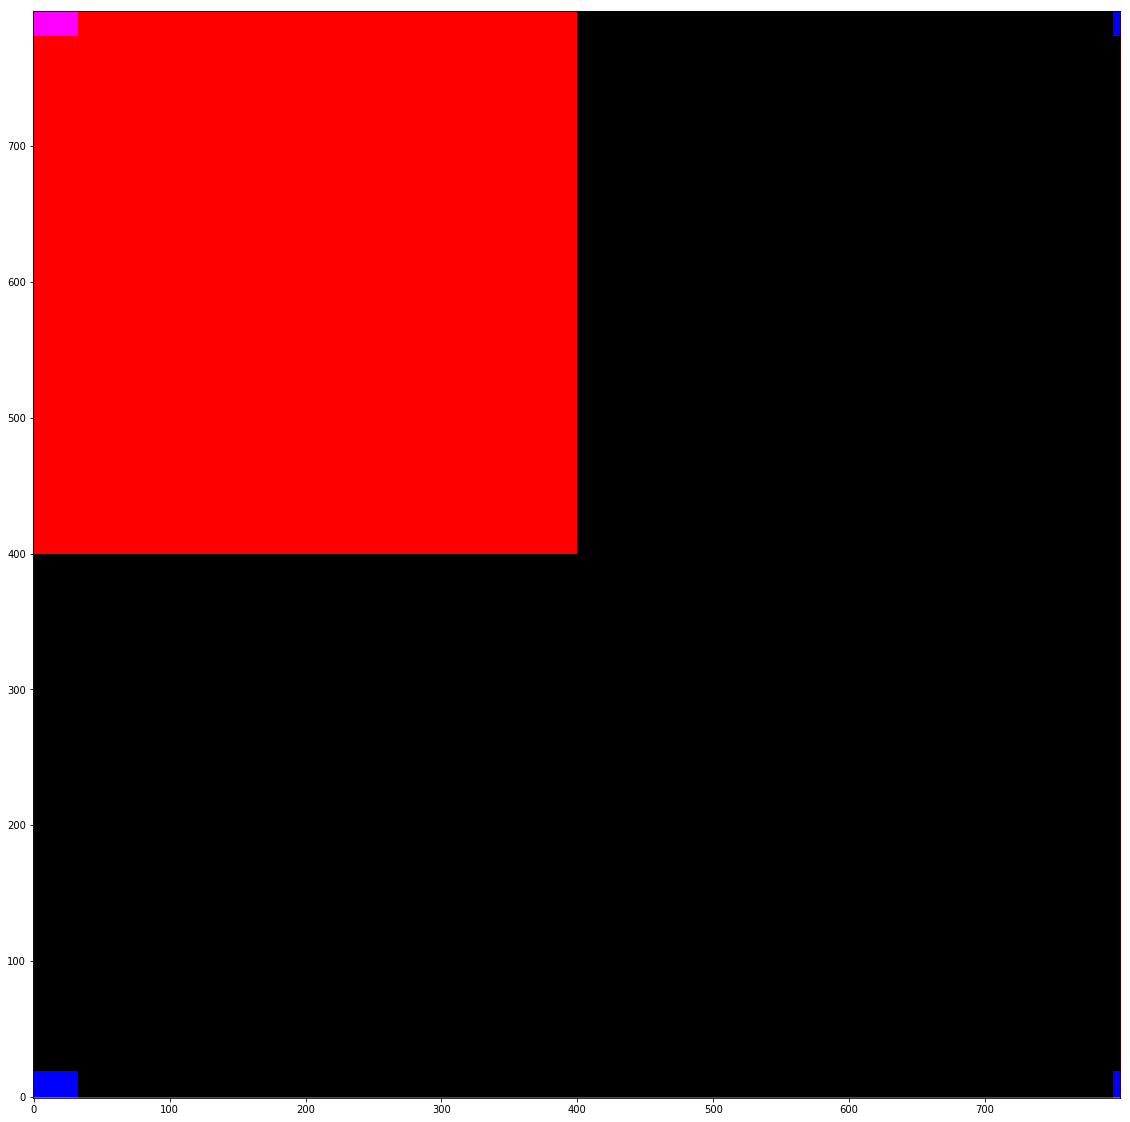

In [1]:
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import numpy as np
import matplotlib.pyplot as plt
from parse import *
import math
%matplotlib inline
from ast import literal_eval as make_tuple
robot = Robot.robot(0,0,0)
#coord_robot = robot.get_beacon_position()
#print("Robot is in :" ,coord_robot)
#robot.set_position(X_robot , Y_robot, Angle_robot)
#print(robot.set_sensor_state(2048+16))
mapper = Map_Generator.Mapping()
grid_updated=mapper.map()

checkpoint_, robot = goto_objective(Set_Objective,robot,mapper)
mapper.display([],robot,[])



# Old Main loop (Astar :)

In [11]:
s.close()

In [1]:

import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import numpy as np
import matplotlib.pyplot as plt
from parse import *
import math
%matplotlib inline
from ast import literal_eval as make_tuple
robot = Robot.robot(0,0,0)
"""
if beacon_coordinate != None :

    command = "G92 X"+ "{:0.2f}".format(beacon_coordinate[0]) +" Y"+"{:0.2f}".format(beacon_coordinate[1])+ " A"+ "{:0.2f}".format(beacon_coordinate[2])+"\r\n"
    buf_stm.append(command)
    print(command)
"""

'\nif beacon_coordinate != None :\n\n    command = "G92 X"+ "{:0.2f}".format(beacon_coordinate[0]) +" Y"+"{:0.2f}".format(beacon_coordinate[1])+ " A"+ "{:0.2f}".format(beacon_coordinate[2])+"\r\n"\n    buf_stm.append(command)\n    print(command)\n'

In [2]:
beacon_coordinate = robot.get_beacon_position()
print("Beacon: ",beacon_coordinate)

/home/pi/.local/lib/python3.5/site-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 1920x1080 to 1920x1088
  width, height, fwidth, fheight)))


[0, 1, 2]
Beacon:  [[4619.374438983111, 3944.0661915637, -2.090489513927635]]
